<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/claim_occurrence_Finality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('telematics_syn.csv')



# Step 1: Inspect the Dataset


In [ ]:
# Check the first few rows
print(data.head())

# Check data types and missing values
print(data.info())

# Summary statistics
print(data.describe())

   Duration  Insured.age Insured.sex  Car.age  Marital  Car.use  Credit.score  \
0       366           45        Male       -1  Married  Commute         609.0   
1       182           44      Female        3  Married  Commute         575.0   
2       184           48      Female        6  Married  Commute         847.0   
3       183           71        Male        6  Married  Private         842.0   
4       183           84        Male       10  Married  Private         856.0   

  Region  Annual.miles.drive  Years.noclaims  ...  Left.turn.intensity10  \
0  Urban             6213.71              25  ...                    1.0   
1  Urban            12427.42              20  ...                   58.0   
2  Urban            12427.42              14  ...                    0.0   
3  Urban             6213.71              43  ...                    0.0   
4  Urban             6213.71              65  ...                    2.0   

   Left.turn.intensity11  Left.turn.intensity12  Right.t

# Step 2: Handle Missing Values


In [ ]:
# Drop the single row with missing values
data.dropna(inplace=True)

## Step 2.1. Fix Invalid Car.age


In [ ]:
# Replace negative values with 0 (assuming data entry error)
data['Car.age'] = data['Car.age'].clip(lower=0)

# 3. Encode Categorical Variables


In [ ]:
# One-hot encode categorical features
cat_cols = ['Insured.sex', 'Marital', 'Car.use', 'Region']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# 4. Separate Features & Target


In [ ]:
X = data.drop(['NB_Claim', 'AMT_Claim'], axis=1)  # Features
y = data['NB_Claim']  # Binary classification target (Claim Yes/No)

# 5. Split Data


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Address Class Imbalance with SMOTE


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({0.0: 61263, 1.0: 61263, 2.0: 61263, 3.0: 61263})


# 7. Feature Scaling (Critical for Linear Models)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

[0]	validation_0-aucpr:0.11334
[20]	validation_0-aucpr:0.23436
[40]	validation_0-aucpr:0.30146
[60]	validation_0-aucpr:0.34659
[80]	validation_0-aucpr:0.39406
[100]	validation_0-aucpr:0.43499
[120]	validation_0-aucpr:0.47278
[140]	validation_0-aucpr:0.49980
[160]	validation_0-aucpr:0.52007
[180]	validation_0-aucpr:0.53444
[200]	validation_0-aucpr:0.55826
[220]	validation_0-aucpr:0.56820
[240]	validation_0-aucpr:0.58425
[260]	validation_0-aucpr:0.60043
[280]	validation_0-aucpr:0.61001
[300]	validation_0-aucpr:0.62117
[320]	validation_0-aucpr:0.63071
[340]	validation_0-aucpr:0.63477
[360]	validation_0-aucpr:0.64332
[380]	validation_0-aucpr:0.64928
[400]	validation_0-aucpr:0.65370
[420]	validation_0-aucpr:0.65643
[440]	validation_0-aucpr:0.66175
[460]	validation_0-aucpr:0.66570
[480]	validation_0-aucpr:0.66896
[500]	validation_0-aucpr:0.67116
[520]	validation_0-aucpr:0.67257
[540]	validation_0-aucpr:0.67340
[560]	validation_0-aucpr:0.67555
[580]	validation_0-aucpr:0.67859
[600]	validation

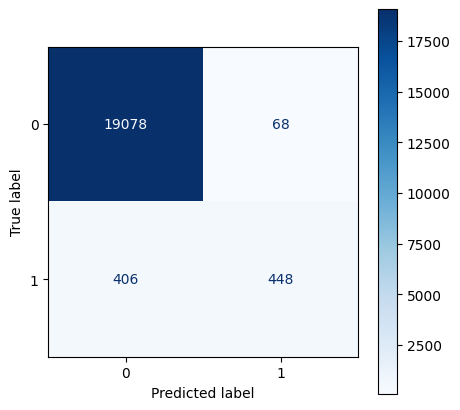

In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('telematics_syn.csv')
data.dropna(inplace=True)
data['Car.age'] = data['Car.age'].clip(lower=0)

# Convert NB_Claim to binary (0 = no claim, 1 = any claim)
data['NB_Claim'] = (data['NB_Claim'] > 0).astype(int)  # Critical fix

# Encode categorical variables
cat_cols = ['Insured.sex', 'Marital', 'Car.use', 'Region']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# Split data
X = data.drop(['NB_Claim', 'AMT_Claim'], axis=1)
y = data['NB_Claim']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# XGBoost Classifier - Remove scale_pos_weight
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=1000,
    early_stopping_rounds=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model
model.fit(
    X_res, y_res,
    eval_set=[(X_test, y_test)],
    verbose=20
)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]  # Probability of class 1

print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.show()

- Key Insights:
    - Class Imbalance Handling:

    - Total samples = 19078 + 68 + 406 + 448 = 20,000

    - Class distribution:

        - Class 0 (No Claim): 19,146 samples (95.7%)

        - Class 1 (Claim): 854 samples (4.3%)

```
TN = 19078, FP = 68
FN = 406, TP = 448

Accuracy = (TN + TP) / Total = (19078 + 448)/20000 = 97.63%
Precision = TP / (TP + FP) = 448 / (448 + 68) = 86.8%
Recall = TP / (TP + FN) = 448 / (448 + 406) = 52.5%
F1 = 2*(Precision*Recall)/(Precision+Recall) = 65.4%
```

Critical Observations:

- High False Negatives: 406 missed claims (critical for insurance risk prediction)

- Conservative Predictions: Model prioritizes precision (86.8%) over recall (52.5%)

- Class 0 Dominance: Excellent specificity (TN/(TN+FP) = 99.6%)